# Interpolation

The aim of this practical session is to predict the concentration of Cobalt (mg/kg) in unknown points of the domain in Jura with regression and interpolation techniques by using the X and Y coordinates of the points, the rock type and the land use type

## Load Packages

In [1]:
import numpy as np
import pandas as pd
import gstlearn as gl
import gstlearn.plot as gp
import matplotlib.pyplot as plt
np.random.seed(0)


## Load the data set and the prediction grid


We start by loading the data and the prediction grid

In [3]:
# Dataset
jura_all=pd.read_csv("jura/jura_pred.csv")
# Prediction grid
grid = pd.read_csv("jura/jura_grid.csv")

Change the names of the Land Use and Rock in order to be consistent with their names on the grid

In [4]:
## Replace landuse interger code by name
landuse_codes=[1,2,3,4]
landuse_names=["Forest","Pasture","Meadow","Tillage"]
jura_all["Landuse"]=jura_all["Landuse"].replace(landuse_codes,landuse_names)

## Replace rock type interger code by name
rock_codes=[1,2,3,4,5]
rock_names=["Argovian","Kimmeridgian","Sequanian","Portlandian","Quaternary"]
jura_all["Rock"]=jura_all["Rock"].replace(rock_codes,rock_names)

Separate the data set in two sets : the training set and the validation set.
For the project and the Kaggle competition, you should use the full data set for 
the training.
You will submit your prediction on Kaggle for a set of locations on which you will 
only know the locations and the factors of Land Use and Rock at these locations.

In [5]:
ntot = jura_all.shape[0]
ntrain = 200
nval = ntot - ntrain

indtrain = np.random.choice(ntot,ntrain).astype(int)
indval = np.setdiff1d(np.arange(ntot),indtrain)

jura =jura_all.loc[indtrain,:]

#val contains the values to predict. For the project, these values will be on Kaggle
#(for other locations) and you won't know them
#You will have the locations and covariables at the unknown locations by the following command :
val_loc =jura_all.loc[indval,['Xloc','Yloc','Landuse','Rock']]
val=jura_all.loc[indval,['Co']]

gstlearn utilities for display (just run the chunk)

In [6]:
### Load grid data into  point database
db_grid_pts=gl.Db_fromPanda(grid)
db_grid_pts.setLocators(["Xloc","Yloc"],gl.ELoc.X)
db_grid_pts["Landuse"]=grid["Landuse"].replace(landuse_names,landuse_codes) ## String names are not supported
db_grid_pts["Rock"]=grid["Rock"].replace(rock_names,rock_codes) ## String names are not supported

### Create empty grid database with right dimensions
xgrid=np.unique(db_grid_pts["Xloc"])
ygrid=np.unique(db_grid_pts["Yloc"])
db_grid=gl.DbGrid.create(nx=[len(xgrid),len(ygrid)],
                         dx=[xgrid[1]-xgrid[0],ygrid[1]-ygrid[0]],
                         x0=[xgrid[0],ygrid[0]])

### Migrate variables from point database to grid database
err=gl.migrateMulti(db_grid_pts,db_grid,
                    names=["Landuse","Rock"],
                    namconv=gl.NamingConvention())

### Add selection 
db_grid.addSelection(~np.isnan(db_grid["Landuse"]))

## Function to add a variable to a grid database
def add_variable(var,db_pts_in,db_grid_out,name):
  db_pts_copy=gl.Db(db_pts_in)
  db_pts_copy[name]=var ## Add variable
  
  db_grid_out_copy=gl.DbGrid(db_grid_out)
  err=gl.migrateMulti(db_pts_copy,db_grid_out_copy,
                    names=[name],
                    namconv=gl.NamingConvention())
  
  return db_grid_out_copy


### Display content
db_grid.display()


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 6
Total number of samples      = 11349
Number of active samples     = 5957

Grid characteristics:
---------------------
Origin :      0.300     0.100
Mesh   :      0.050     0.050
Number :         97       117

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = Landuse - Locator = z1
Column = 4 - Name = Rock - Locator = z2
Column = 5 - Name = NewSel - Locator = sel


c:\Temp\ipykernel_10772\1418212722.py:4: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

c:\Temp\ipykernel_10772\1418212722.py:5: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



c:\Temp\ipykernel_10772\2067275888.py:4: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



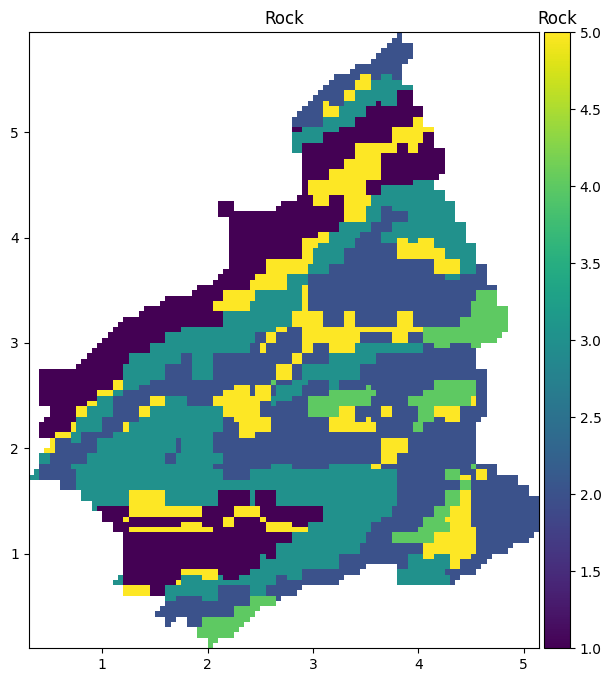

In [7]:
### Plot rock types (to check)
fig,ax = gp.initGeographic()
ax.raster(db_grid,name="Rock",flagLegend=True)
fig.show()

## Regression and interpolation techniques 

### 1. Prediction by the mean

In [8]:
# Compute mean of Co observations 
mean_value = np.mean(jura['Co'])
print("Mean of Co observations  : ",mean_value)

# Compute score 
print("MSE : ",np.mean((mean_value-val['Co'])**2))

Mean of Co observations  :  9.11878
MSE :  14.27848461699504


### 2. ANOVA

To perform a linear regression with categorical variables, we use the *ols* function from the *statsmodels* package.

In [9]:
## For linear regressions (using R-style formulas to define regression)
from statsmodels.formula.api import ols

In [ ]:
# Fit the regression model
model_aov = ols(formula='Co ~  Landuse + Rock + Landuse * Rock', data=jura).fit()
print(model_aov.summary())

                            OLS Regression Results                            
Dep. Variable:                     Co   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     18.32
Date:                Mon, 18 Nov 2024   Prob (F-statistic):           4.96e-28
Time:                        13:55:25   Log-Likelihood:                -438.71
No. Observations:                 200   AIC:                             907.4
Df Residuals:                     185   BIC:                             956.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

d:\Documents\git\lecture-geostatistics\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning:

divide by zero encountered in scalar divide



To perform an ANOVA analysis, we use the *stats.anova_lm* function from the *statsmodels* package.

In [11]:
## For ANOVA regressions
from statsmodels.api import stats

In [12]:
# Perform anova analysis
anova_table = stats.anova_lm(model_aov)
print(anova_table)

                 df      sum_sq     mean_sq          F        PR(>F)
Landuse         3.0  201.966289   67.322096  13.227991  7.315066e-08
Rock            4.0  771.003539  192.750885  37.873257  3.962436e-23
Landuse:Rock   12.0  359.722191   29.976849   5.890094  1.239208e-08
Residual      185.0  941.532810    5.089367        NaN           NaN


c:\Temp\ipykernel_10772\3470724266.py:9: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



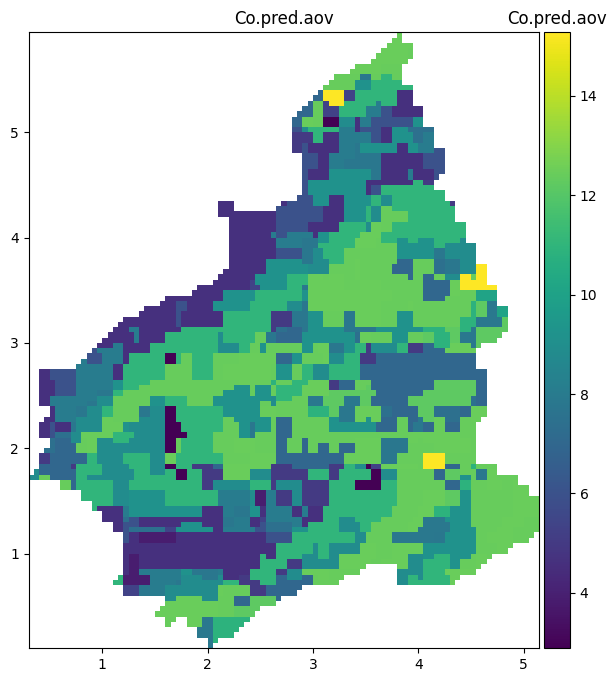

In [ ]:
# Prediction on the grid
res_aov=model_aov.predict(grid)

## Plot results
res_name="Co.pred.aov"
grid_plt=add_variable(res_aov,db_grid_pts,db_grid,res_name)
fig,ax = gp.initGeographic()
ax.raster(grid_plt,name=res_name, flagLegend=True)
fig.show()

In [14]:
val_loc_k=pd.read_csv("jura/jura_val_loc.csv")
val_loc_k["Landuse"]=val_loc_k["Landuse"].replace(landuse_codes,landuse_names)
val_loc_k["Rock"]=val_loc_k["Rock"].replace(rock_codes,rock_names)

#Fit the regression model
model_aov = ols(formula='Co ~  Landuse + Rock + Landuse * Rock', data=jura_all).fit()
print(model_aov.summary())

#Perform anova analysis
anova_table = stats.anova_lm(model_aov)
print(anova_table)

#Prediction on the validation locations
res_aov_val=model_aov.predict(val_loc_k)

### Keep in mind to submit to Kaggle
to_kaggle = pd.DataFrame({"V1" : range(1,val_loc_k.shape[0]+1), "V2" : res_aov_val.to_numpy()})
to_kaggle.to_csv('submission1.csv',index=False)

                            OLS Regression Results                            
Dep. Variable:                     Co   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     12.78
Date:                Mon, 18 Nov 2024   Prob (F-statistic):           3.45e-25
Time:                        13:59:09   Log-Likelihood:                -613.81
No. Observations:                 259   AIC:                             1264.
Df Residuals:                     241   BIC:                             1328.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [15]:
# Prediction on the validation locations
res_val_aov=model_aov.predict(val_loc)

#Compute score 
print("MSE : ",np.mean((res_val_aov-val['Co'])**2))

MSE :  8.089914125084894


### 3. Linear regression of functions of coordinates

To perform a coordinate-based linear regression, we use the *ols* function from the *statsmodels* package.

In [16]:
# Fit the linear regression  model
model_trend = ols(formula='Co~Xloc+Yloc+Xloc*Yloc+Xloc**2+Yloc**2', data=jura).fit()
model_trend.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Co   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     9.441
Date:                Mon, 18 Nov 2024   Prob (F-statistic):           7.41e-06
Time:                        14:03:30   Log-Likelihood:                -512.20
No. Observations:                 200   AIC:                             1032.
Df Residuals:                     196   BIC:                             1046.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.5959      1.781      5.389      0.000       6.084      13.108
Xloc           0.4760      0.576      0.826      0.410      -0.660       1.612
Yloc          -1.6849      0.799     -2.109      0.036      -3.260      -0.109
Xloc:Yloc      0.3302      0.247      1.338      0.182      -0.156       0.817
==============================================================================
Omnibus:                        2.879   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.237   Jarque-Bera (JB):                2.811
Skew:                          -0.236   Prob(JB):                        0.245
Kurtosis:                       2.662   Cond. No.                         96.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

c:\Temp\ipykernel_10772\1894086083.py:9: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



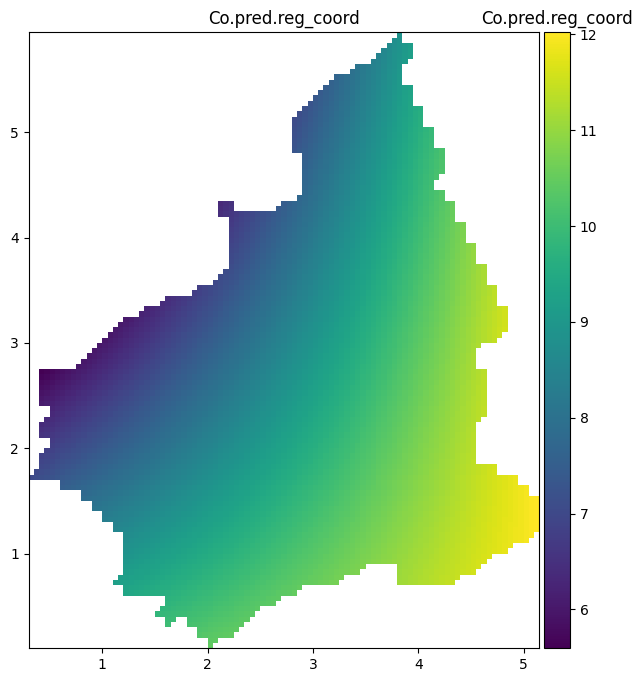

In [17]:
## Prediction on the grid
res_trend=model_trend.predict(grid)

## Plot results
res_name="Co.pred.reg_coord"
grid_plt=add_variable(res_trend,db_grid_pts,db_grid,res_name)
fig,ax = gp.initGeographic()
ax.raster(grid_plt,name=res_name, flagLegend=True)
fig.show()

In [18]:
#Prediction on the validation locations
res_val_trend=model_trend.predict(val_loc)

#Compute score 
print("MSE : ",np.mean((res_val_trend-val['Co'])**2))

MSE :  11.898419681355984


### 4. Nearest neighbors

To perform nearest neighbors regression, we use the *KNeighborsRegressor* function from the *scikit-learn* package.

In [20]:
## k-Nearest neighbors
from sklearn.neighbors import KNeighborsRegressor

In [21]:
## Fit model
model_knn = KNeighborsRegressor(n_neighbors=2)
model_knn.fit(jura[['Xloc','Yloc']], jura['Co'])

KNeighborsRegressor(n_neighbors=2)

c:\Temp\ipykernel_10772\3561592399.py:9: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



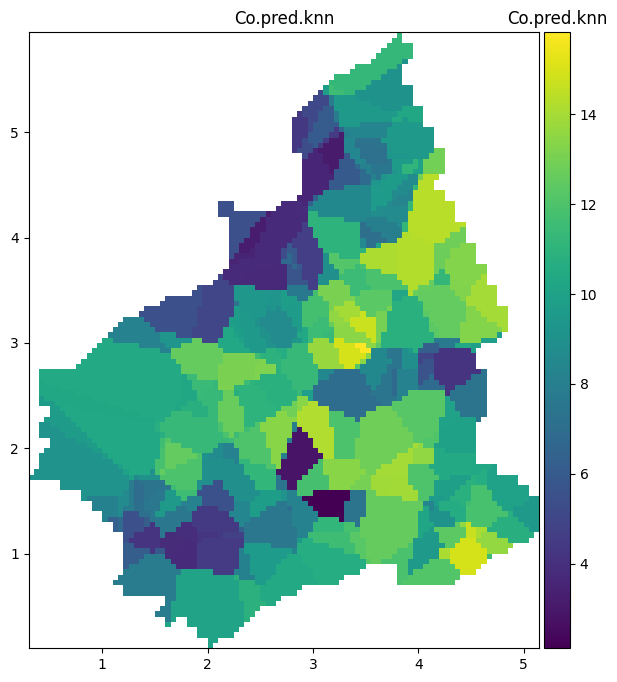

In [22]:
## Prediction on the grid
res_knn=model_knn.predict(grid[['Xloc','Yloc']])

## Plot results
res_name="Co.pred.knn"
grid_plt=add_variable(res_knn,db_grid_pts,db_grid,res_name)
fig,ax = gp.initGeographic()
ax.raster(grid_plt,name=res_name, flagLegend=True)
fig.show()

In [23]:
## Prediction on the validation locations
res_val_knn=model_knn.predict(val_loc[['Xloc','Yloc']])

## Compute score 
print("MSE : ",np.mean((res_val_knn-val['Co'])**2))

MSE :  4.395282247933885


### 5. Inverse distance

To perform inverse distance regression, we use the *RadiusNeighborsRegressor* function from the *scikit-learn* package.

In [24]:
## Radius neighbors regression
from sklearn.neighbors import RadiusNeighborsRegressor

In [25]:
## Fit model
model_invdist = RadiusNeighborsRegressor(radius=10,weights='distance') ## Take a big radius to include all points
model_invdist.fit(jura[['Xloc','Yloc']], jura['Co'])

RadiusNeighborsRegressor(radius=10, weights='distance')

c:\Temp\ipykernel_10772\2409378337.py:9: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



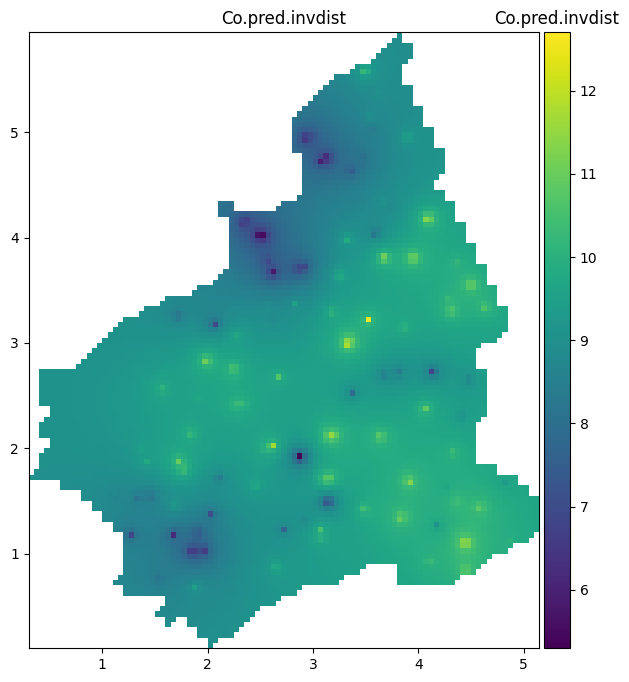

In [26]:
## Prediction on the grid
res_invdist=model_invdist.predict(grid[['Xloc','Yloc']])

## Plot results
res_name="Co.pred.invdist"
grid_plt=add_variable(res_invdist,db_grid_pts,db_grid,res_name)
fig,ax = gp.initGeographic()
ax.raster(grid_plt,name=res_name, flagLegend=True)
fig.show()

In [27]:
## Prediction on the validation locations
res_val_invdist=model_invdist.predict(val_loc[['Xloc','Yloc']])

## Compute score 
print("MSE : ",np.mean((res_val_invdist-val['Co'])**2))

MSE :  7.377512189070061


## Exercises : 

1) Improve the prediction by using other parameterizations for the previous methods.

2) Use other methods (Local Polynomial Regression, Random Forests, ...).

3) Predict on the locations in the file 'jura_val_loc.csv' and submit your prediction to
[the kaggle competition](https://www.kaggle.com/t/d42c5515d6db40f7a43f9c7ab3f6dee8)

MSE :  5.199712272969954


c:\Temp\ipykernel_10772\2951970132.py:16: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



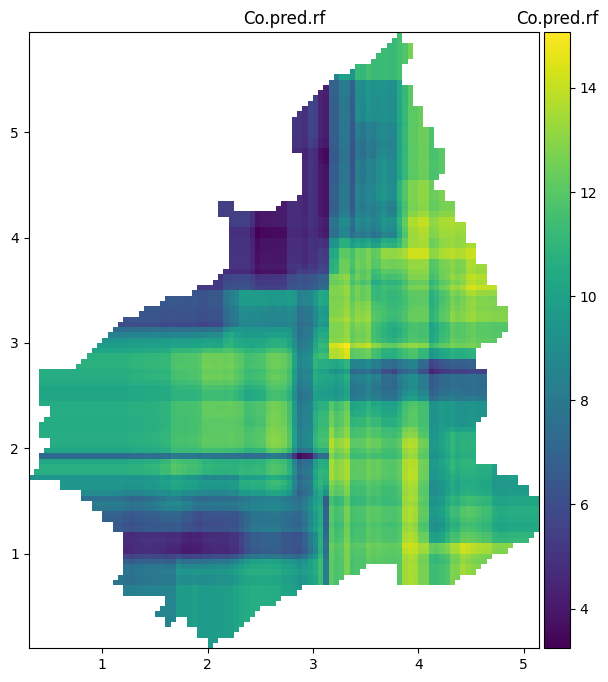

In [ ]:
## Random forest
from sklearn.ensemble import RandomForestRegressor

## Fit model
model_rf = RandomForestRegressor(n_estimators=100,max_depth=10)
model_rf.fit(jura[['Xloc','Yloc']], jura['Co'])

## Prediction on the grid
res_rf=model_rf.predict(grid[['Xloc','Yloc']])

## Plot results
res_name="Co.pred.rf"
grid_plt=add_variable(res_rf,db_grid_pts,db_grid,res_name)
fig,ax = gp.initGeographic()
ax.raster(grid_plt,name=res_name, flagLegend=True)
fig.show()

## Prediction on the validation locations
res_val_rf=model_rf.predict(val_loc[['Xloc','Yloc']])

## Compute score 
print("MSE : ",np.mean((res_val_rf-val['Co'])**2))

In [29]:
print(jura)

      Xloc   Yloc  Landuse          Rock     Cd      Co     Cr      Cu     Ni  \
172  3.644  2.677   Forest  Kimmeridgian  0.930   9.560  37.40   6.772  23.12   
47   3.120  1.469   Forest     Sequanian  1.910   2.120  31.12  11.600   8.00   
117  3.669  4.291  Pasture     Sequanian  1.917   8.440  33.48   8.400  18.72   
192  1.350  1.970  Pasture     Sequanian  3.810  10.120  60.80  17.920  27.08   
251  3.925  3.779   Meadow    Quaternary  0.855  14.240  29.20  11.400  21.00   
..     ...    ...      ...           ...    ...     ...    ...     ...    ...   
241  4.788  1.647   Meadow  Kimmeridgian  0.720   8.800  34.08  11.400  26.72   
146  4.426  0.821  Pasture  Kimmeridgian  0.805  13.000  48.32   8.760  26.00   
221  2.537  3.768   Meadow      Argovian  0.230   3.792  18.20   8.720   5.68   
2    2.807  3.347  Pasture     Sequanian  1.610  10.600  47.00   8.880  21.40   
69   3.452  4.736  Pasture    Quaternary  2.960   7.200  45.20  38.960  15.00   

        Pb      Zn  
172  5

In [34]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# One-hot encode the categorical columns 'Rock' and 'Landuse'
jura_encoded = pd.get_dummies(jura, columns=['Rock', 'Landuse'])
val_loc_encoded = pd.get_dummies(val_loc, columns=['Rock', 'Landuse'])

# Align validation columns to match training columns, filling missing columns with 0
val_loc_encoded = val_loc_encoded.reindex(columns=jura_encoded.columns.drop('Co'), fill_value=0)

# Define the feature columns (all except the target variable 'Co')
feature_columns = ['Xloc', 'Yloc'] + [col for col in jura_encoded.columns if col.startswith('Rock_') or col.startswith('Landuse_')]

# Fit the Random Forest model using the one-hot encoded features
model_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model_rf.fit(jura_encoded[feature_columns], jura_encoded['Co'])

# Prediction on the grid (align grid DataFrame with training features)
grid_encoded = pd.get_dummies(grid, columns=['Rock', 'Landuse'])
grid_encoded = grid_encoded.reindex(columns=feature_columns, fill_value=0)

# Prediction on the grid using the aligned feature set
res_rf = model_rf.predict(grid_encoded[feature_columns])

# Prediction on the validation locations
res_val_rf = model_rf.predict(val_loc_encoded[feature_columns])

# Compute score (Mean Squared Error)
mse = mean_squared_error(val['Co'], res_val_rf)
print("MSE: ", mse)



MSE:  5.925792191976816
